In [1]:
pip install -U pandasql

Requirement already up-to-date: pandasql in c:\users\crie072\anaconda3\lib\site-packages (0.7.3)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import csv
import xlrd
import io
from zipfile import ZipFile
from datetime import date, timedelta, time, datetime

import glob

import argparse
import logging
import os

from pathlib import Path

from pandasql import sqldf

In [3]:
today_yyyymmdd = date.today().strftime("%Y%m%d")
print(today_yyyymmdd)

20200912


In [4]:
#pandasの表示列数を増やす
import pandas as pd
pd.set_option('display.max_columns', 100)

ディレクトリ

In [5]:
data_dir = Path(r"C:\Users\crie072\Documents\01_データ関連\Adhoc\202008_消費者還元")

インプット ※経営管理からのリストデータを取込

In [52]:
path = r"C:\Users\crie072\Documents\01_データ関連\Adhoc\202008_消費者還元" # use your path
all_files = glob.glob(path + "/*.csv")

li = []
 
for filename in all_files:
    df = pd.read_csv(filename, usecols=['売上年月日',
                                        '決済金額',
                                        '屋号（漢字）',
                                        '還元率','PAN',
                                        '代表顧客番号',
                                        'カ－ド提携会社コ－ド１',
                                        'カ－ド提携会社コ－ド２',
                                        'カード種類コード',
                                        'ブランドコ－ド',
                                        '取引CD',
                                        '還元対象フラグ',
                                        '利用フラグ']
                     ,encoding="cp932",
                    dtype={'PAN':str,'代表顧客番号':str})
    li.append(df)
df_all = pd.concat(li, axis=0, ignore_index=True)
df_all

,PAN,取引CD,売上年月日,決済金額,屋号（漢字）,還元率,還元対象フラグ,利用フラグ,代表顧客番号,カ－ド提携会社コ－ド１,カ－ド提携会社コ－ド２,カード種類コード,ブランドコ－ド
0,4980121001365006,2,191007,1628,ダイコクドラッグ狸小路４丁目店,5,NaN,0,155200389791,D00,1,31,1
1,4980121001365006,2,191029,10527,モッズ ヘア 西宮店,2,NaN,0,155200389791,D00,1,31,1
2,4980121001712017,2,191016,12760,鉄板焼れすとらん中はら,5,NaN,0,155200434647,D00,1,31,1
3,4980121002072106,2,191005,21967,牛もつどて鍋 まつい亭,5,NaN,0,155200740472,D00,1,31,1
4,4980121002401016,2,191008,3853,マルヤス吹田新芦屋店,5,NaN,0,155200803650,D00,1,31,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3851474,4980671573746017,2,191228,122720,ａｕ ＫＹＯＴＯ,2,NaN,0,155233261520,D02,1,2,1
3851475,5279253279334005,2,191228,12650,ＡＳＡＮＴＥＮＩ,5,NaN,0,155233257049,D00,4,31,2
3851476,4980671574154005,2,191229,30600,ホテルはちまん,5,NaN,0,155233266719,D02,1,2,1
3851477,4980671574154005,2,191229,77319,レストラン ティファニー,5,NaN,0,155233266719,D02,1,2,1


In [42]:
df_all['PAN'].nunique()

423511

In [43]:
df_all['代表顧客番号'].nunique()

327686

In [53]:
df_all = df_all.sort_values(['PAN','売上年月日'])

In [49]:
df_all.head()

,PAN,取引CD,売上年月日,決済金額,屋号（漢字）,還元率,還元対象フラグ,利用フラグ,代表顧客番号,カ－ド提携会社コ－ド１,カ－ド提携会社コ－ド２,カード種類コード,ブランドコ－ド
254832,4980006000075010,2,191116,7810,東京竹葉亭 西宮店,5,NaN,0,1.55213E+11,D00,1,2,1
254833,4980006000075010,2,191123,4455,すじかま,5,NaN,0,1.55213E+11,D00,1,2,1
254834,4980006000075010,2,191126,24068,ティンカームーン,5,NaN,0,1.55213E+11,D00,1,2,1
26551,4980006000075013,2,191006,7200,ｆｒｏｍ ＣＯＣＯＲＯ,5,NaN,0,155212683645,D00,1,2,1
26552,4980006000075013,2,191026,13200,ぽん多本家,5,NaN,0,155212683645,D00,1,2,1


In [37]:
df_all['利用フラグ'].unique() #利用フラグ 0=VM利用

array([0], dtype=int64)

In [38]:
df_all['還元対象フラグ'].unique() #還元対象フラグ　空白セル　還元対象

array([nan, 'C', 'D', 'E', 'B', 'J'], dtype=object)

In [54]:
df_all['取引CD'].unique() #取引ＣＤ　2売上　4.戻り　7.障害取消

array([2, 4, 7], dtype=int64)

for i in range(len(df_all)):
    if df_all['取引CD'][i] == 7:
        df_all.loc[:,'決済金額'][i] = df_all['決済金額']*-1

for i in range(len(df_all)):
    if df_all['取引CD'][i] == 4:
        df_all.loc[:,'決済金額'][i] = df_all['決済金額']*-1

In [61]:
df_all =df_all[(df_all['利用フラグ'] == 0)]#VM利用に限定

In [62]:
df_all =df_all.query('not 還元対象フラグ == ["C","D","E","B","J"]')#還元対象に限定

In [63]:
df_all['還元対象フラグ'].unique()

array([nan], dtype=object)

In [21]:
print(df_all.dtypes)

PAN            object
取引CD            int64
売上年月日           int64
決済金額            int64
屋号（漢字）         object
還元率             int64
還元対象フラグ        object
利用フラグ           int64
代表顧客番号         object
カ－ド提携会社コ－ド１    object
カ－ド提携会社コ－ド２     int64
カード種類コード        int64
ブランドコ－ド         int64
dtype: object


In [64]:
df_all['PAN'].nunique()

418856

In [65]:
df_all['代表顧客番号'].nunique()

326863

In [66]:
df_all['決済金額'].describe()/1000

count    3784.007000
mean        8.219514
std        27.735592
min         0.020000
25%         1.606000
50%         3.309000
75%         7.040000
max      8250.000000
Name: 決済金額, dtype: float64

In [67]:
_df_all = df_all.copy()#backup

In [68]:
#余白の削除
df_all['PAN'] = df_all['PAN'].str.strip()
df_all['代表顧客番号'] = df_all['代表顧客番号'].str.strip()

In [69]:
df_all.head()

,PAN,取引CD,売上年月日,決済金額,屋号（漢字）,還元率,還元対象フラグ,利用フラグ,代表顧客番号,カ－ド提携会社コ－ド１,カ－ド提携会社コ－ド２,カード種類コード,ブランドコ－ド
254832,4980006000075010,2,191116,7810,東京竹葉亭 西宮店,5,NaN,0,1.55213E+11,D00,1,2,1
254833,4980006000075010,2,191123,4455,すじかま,5,NaN,0,1.55213E+11,D00,1,2,1
254834,4980006000075010,2,191126,24068,ティンカームーン,5,NaN,0,1.55213E+11,D00,1,2,1
26551,4980006000075013,2,191006,7200,ｆｒｏｍ ＣＯＣＯＲＯ,5,NaN,0,155212683645,D00,1,2,1
26552,4980006000075013,2,191026,13200,ぽん多本家,5,NaN,0,155212683645,D00,1,2,1


アウトプット

In [70]:
result = "no_of_use_months2"
result2 = "shoplist_ranking_by_trn"
list_all = "統合リスト"

In [71]:
df_all = df_all.rename(columns={'売上年月日':'shopping_dt',
                                '決済金額':'shopping_amt',
                                '屋号（漢字）':'shop_name',
                                '還元率':'cb_rate',
                                '代表顧客番号':'daihyouno',
                                'カ－ド提携会社コ－ド１':'teikei_cd1',
                                'カ－ド提携会社コ－ド２':'teikei_cd2',
                                'カード種類コード':'card_cd',
                                'ブランドコ－ド':'brand_cd',
                                '取引CD':'transaction_cd',
                                '還元対象フラグ':'cb_flag',
                                '利用フラグ':'use_flag'})
df_all.head(1)

,PAN,transaction_cd,shopping_dt,shopping_amt,shop_name,cb_rate,cb_flag,use_flag,daihyouno,teikei_cd1,teikei_cd2,card_cd,brand_cd
254832,4980006000075010,2,191116,7810,東京竹葉亭 西宮店,5,NaN,0,1.55213E+11,D00,1,2,1


In [72]:
#日付データの変換
df_all['shopping_dt']=df_all['shopping_dt'] + 20000000
df_all['shopping_dt']=pd.to_datetime(df_all['shopping_dt'], format='%Y%m%d')


df_all['shopping_year'] = df_all['shopping_dt'].dt.year
df_all['shopping_month'] = df_all['shopping_dt'].dt.month
df_all['shopping_day'] = df_all['shopping_dt'].dt.day

df_all['shopping_yymm'] = df_all[['shopping_year','shopping_month']].apply(lambda x:'{}年{}月'.format(x[0],x[1]),axis=1)
df_all

,PAN,transaction_cd,shopping_dt,shopping_amt,shop_name,cb_rate,cb_flag,use_flag,daihyouno,teikei_cd1,teikei_cd2,card_cd,brand_cd,shopping_year,shopping_month,shopping_day,shopping_yymm
254832,4980006000075010,2,2019-11-16,7810,東京竹葉亭 西宮店,5,NaN,0,1.55213E+11,D00,1,2,1,2019,11,16,2019年11月
254833,4980006000075010,2,2019-11-23,4455,すじかま,5,NaN,0,1.55213E+11,D00,1,2,1,2019,11,23,2019年11月
254834,4980006000075010,2,2019-11-26,24068,ティンカームーン,5,NaN,0,1.55213E+11,D00,1,2,1,2019,11,26,2019年11月
26551,4980006000075013,2,2019-10-06,7200,ｆｒｏｍ ＣＯＣＯＲＯ,5,NaN,0,155212683645,D00,1,2,1,2019,10,6,2019年10月
26552,4980006000075013,2,2019-10-26,13200,ぽん多本家,5,NaN,0,155212683645,D00,1,2,1,2019,10,26,2019年10月
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1618063,5279262705817012,2,2020-03-18,3104,よどやドラッグ 土佐道路店,5,NaN,0,155232982167,D02,26,2,2,2020,3,18,2020年3月
1618064,5279262705817012,2,2020-03-24,8252,よどやドラッグ 土佐道路店,5,NaN,0,155232982167,D02,26,2,2,2020,3,24,2020年3月
1176158,5279262705835014,2,2020-01-06,45573,ＡＶＡＮ フジグラン野市店,5,NaN,0,155233129602,D02,26,2,2,2020,1,6,2020年1月
762401,5279262705844008,2,2020-01-18,120000,宮古人形,5,NaN,0,155233304221,D02,26,2,2,2020,1,18,2020年1月


In [73]:
print(df_all.shape)
print(df_all.index)
print(df_all.columns)
print(df_all.dtypes)

(3784007, 17)
Int64Index([ 254832,  254833,  254834,   26551,   26552, 3095922, 3095923,
            3095924, 3479113,  428485,
            ...
             196684, 3413895, 3845745,  755717, 1618062, 1618063, 1618064,
            1176158,  762401, 1626130],
           dtype='int64', length=3784007)
Index(['PAN', 'transaction_cd', 'shopping_dt', 'shopping_amt', 'shop_name',
       'cb_rate', 'cb_flag', 'use_flag', 'daihyouno', 'teikei_cd1',
       'teikei_cd2', 'card_cd', 'brand_cd', 'shopping_year', 'shopping_month',
       'shopping_day', 'shopping_yymm'],
      dtype='object')
PAN                       object
transaction_cd             int64
shopping_dt       datetime64[ns]
shopping_amt               int64
shop_name                 object
cb_rate                    int64
cb_flag                   object
use_flag                   int64
daihyouno                 object
teikei_cd1                object
teikei_cd2                 int64
card_cd                    int64
brand_cd         

In [74]:
#CSVアウトプット
df_all.to_csv(data_dir /f"output"/f'{list_all}.csv', header=True ,index=None, encoding='utf-8-sig')

In [56]:
print(df_all['shop_name'].unique())

['東京竹葉亭  西宮店' 'すじかま' 'ティンカームーン' ... 'ＪＦ北灘さかな市／ｉＤ' 'ラーメンとん太蓮台寺ＰＡ上り／ｉＤ'
 'ラーメンとん太蓮台寺ＰＡ下り／ｉＤ']


In [61]:
df_shoplist = df_all['shop_name'].unique()
df_shoplist

array(['東京竹葉亭  西宮店', 'すじかま', 'ティンカームーン', ..., 'ＪＦ北灘さかな市／ｉＤ',
       'ラーメンとん太蓮台寺ＰＡ上り／ｉＤ', 'ラーメンとん太蓮台寺ＰＡ下り／ｉＤ'], dtype=object)

In [20]:
#月次売上金額(百万円単位)
df_all.groupby(['shopping_yymm'])['shopping_amt'].sum()/1000000

shopping_yymm
2019年10月    2375.837522
2019年11月    4232.068411
2019年12月    4215.761293
2020年1月     3686.593457
2020年2月     3601.217547
2020年3月     3923.259769
2020年4月     2930.462557
2020年5月     3322.258499
2020年6月     3794.666907
Name: shopping_amt, dtype: float64

In [76]:
#集計（追加対応）
q = """
        SELECT
        shopping_yymm
        ,cb_rate
        ,case 
            when teikei_cd1 = "D02" then "外商"
            when teikei_cd2 = 5  then "ハウスゴールド"
            when card_cd = 2  then "ゴールド"
            when card_cd = 31 then "一般"
            else "その他"
            end as card
        ,case
            when brand_cd = 2 then "Master" else "Visa"
            end as brand
        ,count(PAN) as no_of_trn
        ,count(distinct PAN) as uu
        ,sum(case when 4 < transaction_cd then shopping_amt*-1 else shopping_amt end) as sum_shopping_amt
        from 
            df_all
        group by
            1,2,3,4
        
        """
df_tmp = sqldf(q, locals())
df_tmp

,shopping_yymm,cb_rate,card,brand,no_of_trn,uu,sum_shopping_amt
0,2019年10月,2,ゴールド,Master,274,187,1504991
1,2019年10月,2,ゴールド,Visa,1319,841,5668736
2,2019年10月,2,一般,Master,1137,763,3929854
3,2019年10月,2,一般,Visa,6141,4180,28497557
4,2019年10月,2,外商,Master,323,241,2101321
...,...,...,...,...,...,...,...
103,2020年6月,5,ゴールド,Visa,39977,12447,405090463
104,2020年6月,5,一般,Master,40123,14754,305930292
105,2020年6月,5,一般,Visa,232115,83848,1796624112
106,2020年6月,5,外商,Master,14693,4875,156310762


In [77]:
df_tmp.to_csv(data_dir /f"output"/'還元率別決済金額&件数.csv', header=True ,index=None, encoding='utf-8-sig')

In [78]:
df_all['shopping_amt'].describe()/100

count    37840.070000
mean        82.195138
std        277.355920
min          0.200000
25%         16.060000
50%         33.090000
75%         70.400000
max      82500.000000
Name: shopping_amt, dtype: float64

In [79]:
#集計（追加対応）利用金額帯別
q = """
        SELECT
        shopping_yymm
        ,case 
            when teikei_cd1 = "D02" then "外商"
            when teikei_cd2 = 5  then "ハウスゴールド"
            when card_cd = 2  then "ゴールド"
            when card_cd = 31 then "一般"
            else "その他"
            end as card
        ,case
            when brand_cd = 2 then "Master" else "Visa"
            end as brand
        ,case 
            when 5000<shopping_amt then '5_5000円以上'
            when shopping_amt < 500 then '1_500円未満'
            when shopping_amt < 1000 then '2_1000円未満'
            when shopping_amt < 3000 then '3_3000円未満'
            when shopping_amt < 5000 then '4_5000円未満'
            else '5_5000円以上'
            end as amt_range
        ,count(PAN) as no_of_trn
        ,count(distinct PAN) as uu
        from 
            df_all
        group by
            1,2,3,4
        
        """
df_tmp = sqldf(q, locals())
df_tmp

,shopping_yymm,card,brand,amt_range,no_of_trn,uu
0,2019年10月,ゴールド,Master,1_500円未満,219,132
1,2019年10月,ゴールド,Master,2_1000円未満,482,329
2,2019年10月,ゴールド,Master,3_3000円未満,1657,863
3,2019年10月,ゴールド,Master,4_5000円未満,962,637
4,2019年10月,ゴールド,Master,5_5000円以上,1916,1208
...,...,...,...,...,...,...
265,2020年6月,外商,Visa,1_500円未満,2836,1624
266,2020年6月,外商,Visa,2_1000円未満,6600,3783
267,2020年6月,外商,Visa,3_3000円未満,25113,10658
268,2020年6月,外商,Visa,4_5000円未満,15917,9712


In [80]:
df_tmp.to_csv(data_dir /f"output"/'利用金額帯別件数.csv', header=True ,index=None, encoding='utf-8-sig')

C:\Users\crie072\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 24180 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\crie072\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 26376 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\crie072\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 24180 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\crie072\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 26376 missing from current font.
  font.set_text(s, 0, flags=flags)


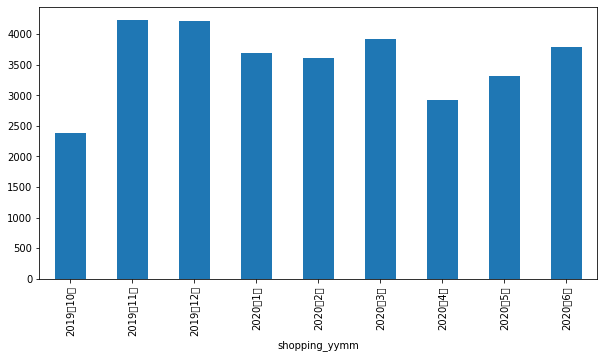

In [21]:
df_tmp = df_all.groupby(['shopping_yymm'])['shopping_amt'].sum()/1000000
df_tmp.plot.bar(x = 'shopping_yymm',y = 'shopping_amt', figsize = (10, 5))

In [22]:
#月次取引数
df_all.groupby(['shopping_yymm'])['PAN'].count()

shopping_yymm
2019年10月    309386
2019年11月    489950
2019年12月    430847
2020年1月     392383
2020年2月     421597
2020年3月     471553
2020年4月     430959
2020年5月     463780
2020年6月     441024
Name: PAN, dtype: int64

In [23]:
#月次ユニーク取引客数
df_all.groupby(['shopping_yymm'])['PAN'].nunique()

shopping_yymm
2019年10月    129528
2019年11月    192458
2019年12月    156689
2020年1月     147961
2020年2月     150070
2020年3月     154134
2020年4月     138403
2020年5月     148746
2020年6月     148584
Name: PAN, dtype: int64

In [24]:
#ユニーク利用者数
df_all['PAN'].nunique()

421951

In [25]:
#ユニーク利用者数
df_all['daihyouno'].nunique()

327686

In [ ]:
df_all['tot_amt_k'].describe()

In [ ]:
#集計（追加）
q = """
        SELECT
        PAN
        ,daihyouno
        ,shopping_yymm
        ,count(PAN) over(partition by PAN order by shopping_yymm) as no_of_use_month
        ,count(PAN) as no_of_trn
        ,sum(shopping_amt) as sum_shopping_amt
        from 
            df_all
        group by
        PAN,shopping_yymm
        """

df_trn = sqldf(q, locals())
df_trn

In [26]:
#このあとやること
#加盟店別取引件数（金額）Top30
#会員別期間内取引月数

In [26]:
print(df_all.dtypes)

PAN                       object
shopping_dt       datetime64[ns]
shopping_amt               int64
shop_name                 object
cb_rate                    int64
daihyouno                 object
shopping_year              int64
shopping_month             int64
shopping_day               int64
shopping_yymm             object
dtype: object


In [59]:
#会員別の利用月数、利用回数、金額を集計① 
q = """
        SELECT
        PAN
        ,daihyouno
        ,shopping_yymm
        ,count(PAN) over(partition by PAN order by shopping_yymm) as no_of_use_month
        ,count(PAN) as no_of_trn
        ,sum(shopping_amt) as sum_shopping_amt
        from 
            df_all
        group by
        PAN,shopping_yymm
        """

df_trn = sqldf(q, locals())
df_trn

,PAN,shopping_yymm,no_of_use_month,no_of_trn,sum_shopping_amt
0,4980006000075010,2019年11月,1,3,36333
1,4980006000075013,2019年10月,1,2,20400
2,4980006000075013,2019年11月,2,3,36333
3,4980006000075013,2019年12月,3,1,7200
4,4980006000075013,2020年1月,4,2,48360
...,...,...,...,...,...
1366568,6900119939001786,2020年6月,1,18,12475
1366569,6900119939001828,2020年6月,1,4,5904
1366570,6900119939001851,2020年6月,1,5,26129
1366571,6900119939002008,2020年6月,1,1,617


#会員ごとの月別利用回数と金額集計
q = """
        SELECT
        PAN
        ,shopping_yymm
        ,count(PAN) as no_of_trn
        ,sum(shopping_amt) as sum_shopping_amt
        from 
            df_all
        group by
        PAN,shopping_yymm
        """

df_trn = sqldf(q, locals())
df_trn

#会員別の利用月数を集計①
q = """
        SELECT
        PAN
        ,shopping_yymm
        ,no_of_trn
        ,count(no_of_trn) over(partition by PAN order by shopping_yymm) as no_of_use_month
        ,sum_shopping_amt
        from 
            df_trn
        group by
        PAN,shopping_yymm
        """

df_trn2 = sqldf(q, locals())
df_trn2

In [60]:
#会員別の利用月数Maxを集計②
q = """
        SELECT
        PAN
        ,sum(no_of_trn) as total_no_trn
        ,max(no_of_use_month) as max_no_use_month
        ,sum(sum_shopping_amt) as total_shopping_amt
        from 
            df_trn
        group by
        PAN
        """

df_max = sqldf(q, locals())
df_max

,PAN,total_no_trn,max_no_use_month,total_shopping_amt
0,4980006000075010,3,1,36333
1,4980006000075013,12,7,147093
2,4980006000075120,20,8,132030
3,4980006000075203,5,4,51329
4,4980006000084000,3,1,4967
...,...,...,...,...
421946,6900119939001786,18,1,12475
421947,6900119939001828,4,1,5904
421948,6900119939001851,5,1,26129
421949,6900119939002008,1,1,617


In [61]:
df_max['PAN'].nunique()

421951

In [62]:
#CSVアウトプット　会員別利用月数
df_max.to_csv(data_dir /f"output"/f'{result}.csv', header=True ,index=None, encoding='shift-jis')
df_max.to_csv(data_dir /f"output"/f'{result}.txt', header=True ,index=None, encoding='shift-jis')

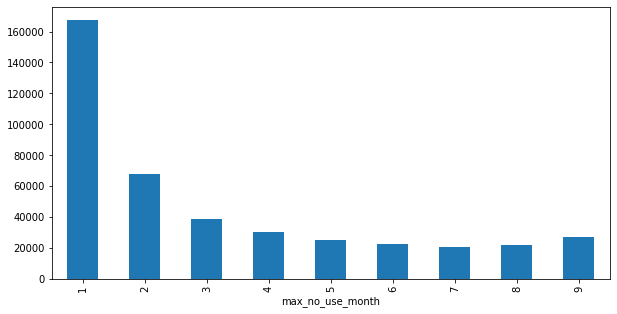

In [63]:
df_tmp = df_max.groupby(['max_no_use_month'])['PAN'].count()
df_tmp.plot.bar(x = 'max_no_use_month',y = 'PAN', figsize = (10, 5))

In [64]:
#会員別の利用月数別の利用実績を集計③
q = """
        SELECT
        max_no_use_month
        ,count(distinct PAN) as sum_account
        ,sum(total_no_trn) as sum_trn
        ,sum(total_shopping_amt) as sum_shopping_amt
        from 
            df_max
        group by
            1
        """

df_max2 = sqldf(q, locals())
df_max2

,max_no_use_month,sum_account,sum_trn,sum_shopping_amt
0,1,167744,237118,4010515847
1,2,67700,247863,2855226000
2,3,38723,191895,2390734862
3,4,30240,223495,2467264608
4,5,25048,256657,2534959279
5,6,22645,309526,2739320428
6,7,20743,386627,3179293988
7,8,21983,559669,4062177332
8,9,27125,1438629,7842633618


In [65]:
#CSVアウトプット　利用月数別金額単価
df_max2.to_csv(data_dir /f"output"/'利用月数別利用金額.csv', header=True ,index=None, encoding='shift-jis')

利用数加盟店Top20

In [33]:
df_all.head(1)

,PAN,shopping_dt,shopping_amt,shop_name,cb_rate,shopping_year,shopping_month,shopping_day,shopping_yymm
0,4980121001365006,2019-10-07,1628,ダイコクドラッグ狸小路４丁目店,5,2019,10,7,2019年10月


In [68]:
q = """
        SELECT
        shop_name
        ,count(PAN) as no_of_trn
        ,sum(shopping_amt) as sum_shopping_amt
        from 
            df_all
        group by
        shop_name
        """

df_shop = sqldf(q, locals())
df_shop

,shop_name,no_of_trn,sum_shopping_amt
0,None,4,230500
1,福島店,3,3270
2,バルス,1,7080
3,丸一高村本店,2,9257
4,丸六本山商店,2,3001
...,...,...,...
170425,ｚｚｚｖ 楽天市場店,3,8551
170426,～エステサロン～ＫＡＴＵＫＩ,2,126129
170427,～ｈａｉｒ．～． ｇｒｅｅｎｒｏｏｍ,16,254551
170428,～ｉｈ,42,1242753


In [69]:
#CSVアウトプット　店舗別売上
df_shop.to_csv(data_dir /f"output"/'店舗別売上.csv', header=True ,index=None, encoding='utf-8-sig')

In [35]:
q = """
        SELECT
        shopping_yymm
        ,shop_name
        ,no_of_trn
        ,sum_shopping_amt
        ,row_number() over(partition by shopping_yymm order by no_of_trn desc) as rank
        from 
            df_shop
        order by
        shopping_yymm,rank
        """

df_shop2 = sqldf(q, locals())
df_shop2

,shopping_yymm,shop_name,no_of_trn,sum_shopping_amt,rank
0,2019年10月,フィール ネットワーク,5615,19261529,1
1,2019年10月,フレスコ 烏丸店,3518,6355827,2
2,2019年10月,フレスコ 御池店,2822,5286989,3
3,2019年10月,吉池,2690,6666988,4
4,2019年10月,京都八百一本館,2481,6463563,5
...,...,...,...,...,...
593680,2020年6月,ｚａｋｋａ ＯＬＩＶＥ 楽天市場店,1,5775,71083
593681,2020年6月,ｚａｋｋａひぐらし,1,2728,71084
593682,2020年6月,ｚｅａｌ ３ａｉｒ,1,7865,71085
593683,2020年6月,ｚｅａｌ ｄ／ｕ／ｅ,1,12048,71086


In [36]:
q = """
        SELECT*
        from 
            df_shop2
        where 
            rank<=20
        order by
        shopping_yymm,rank
        """

df_shop3 = sqldf(q, locals())
df_shop3

,shopping_yymm,shop_name,no_of_trn,sum_shopping_amt,rank
0,2019年10月,フィール ネットワーク,5615,19261529,1
1,2019年10月,フレスコ 烏丸店,3518,6355827,2
2,2019年10月,フレスコ 御池店,2822,5286989,3
3,2019年10月,吉池,2690,6666988,4
4,2019年10月,京都八百一本館,2481,6463563,5
...,...,...,...,...,...
175,2020年6月,寺内,1230,12658004,16
176,2020年6月,フレスコ 四条店,1189,2350935,17
177,2020年6月,フレスコ 五条西洞院店,1175,2391768,18
178,2020年6月,モリタ屋クオリティフードマーケットＳＵＩＮＡ室町店,1160,2910983,19


In [37]:
#CSVアウトプット　利用件数ベースTop20
df_shop3.to_csv(data_dir /f"output"/f'{result2}.csv', header=True ,index=None, encoding='shift-jis')

SASで売上データをマージ

In [6]:
data_dir = Path(r"C:\Users\crie072\Documents\01_データ関連\Adhoc\202008_消費者還元\SAS")

In [7]:
#インプット
input_file1 = "SUM_SHOPPING_TMP.csv"
input_file2 = "SUM_ACCO_cashless.csv"
input_file3 = "キャッシュレス還元有無別売上推移.csv"#9/8追加

In [83]:
#アウトプット
output_file1 = "キャッシュレス売上月次推移"

In [84]:
df_uri = pd.read_csv(data_dir / f"{input_file1}",encoding='shift-jis',dtype = {'max_no_use_month':str})
df_uri = df_uri.sort_values(['credit_dt'])
df_uri = df_uri[df_uri['credit_dt'] >= 20181001]
df_uri.head()

,credit_dt,year,month,card,brand,cashless_f,meti_code,max_no_use_month,sum_hyakkaten_shoping_amt,sum_gaibu_shoping_amt,sum_hyakkaten_shopping_cnt,sum_gaibu_shopping_cnt,sum_shopping_cnt
0,20181001,2018,10,ゴールド,Master,0,0311_百貨店,NaN,4426260,31233,181,4,185
231,20181001,2018,10,外商,Master,0,0316_OCAP他ブランド,NaN,0,6153523,0,802,802
230,20181001,2018,10,外商,Master,0,0315_海外利用,NaN,0,408789,0,35,35
229,20181001,2018,10,外商,Master,0,0312_スーパー・コンビニ・小売り,NaN,0,158,0,1,1
228,20181001,2018,10,外商,Master,0,0311_百貨店,NaN,16806004,120490,1423,5,1428


In [85]:
df_uri.groupby(['year','month'])['sum_shopping_cnt'].sum()

year  month
2018  10       3820641
      11       3948852
      12       4441577
2019  1        3790500
      2        3177574
      3        3557940
      4        3399923
      5        3557398
      6        3551042
      7        3696011
      8        3607834
      9        3693009
      10       3741926
      11       3984824
      12       4540201
2020  1        3915265
      2        3681900
      3        3571048
      4        2655017
      5        2948886
      6        3821139
Name: sum_shopping_cnt, dtype: int64

In [86]:
df_uri['credit_dt']=pd.to_datetime(df_uri['credit_dt'], format='%Y%m%d')
df_uri['credit_dt'] = df_uri['credit_dt'].dt.strftime('%Y/%m/%d')

In [87]:
q = """
        SELECT
        year
        ,month
        ,card
        ,cashless_f
        ,meti_code
        ,sum(sum_gaibu_shoping_amt) as gaibu_shopping_amt
        ,sum(sum_gaibu_shopping_cnt) as gaibu_shopping_cnt
        ,sum(sum_hyakkaten_shoping_amt) as hyakkaten_amt
        ,sum(sum_hyakkaten_shopping_cnt) as hyakkaten_cnt
        from 
            df_uri
        group by 
            1,2,3,4,5
        """
df_ts = sqldf(q, locals())

In [88]:
df_ts

,year,month,card,cashless_f,meti_code,gaibu_shopping_amt,gaibu_shopping_cnt,hyakkaten_amt,hyakkaten_cnt
0,2018,10,ゴールド,0,0311_百貨店,49046175,3545,597184993,32022
1,2018,10,ゴールド,0,0312_スーパー・コンビニ・小売り,100701717,10397,0,0
2,2018,10,ゴールド,0,0313_ホテル・宿泊施設,16612341,438,0,0
3,2018,10,ゴールド,0,0314_飲食店,9479762,915,0,0
4,2018,10,ゴールド,0,0315_海外利用,55801499,3185,0,0
...,...,...,...,...,...,...,...,...,...
1066,2020,6,外商,1,0314_飲食店,65796103,9803,0,0
1067,2020,6,外商,1,0315_海外利用,89137549,7095,0,0
1068,2020,6,外商,1,0316_OCAP他ブランド,2694012507,321000,0,0
1069,2020,6,外商,1,0320_美容・病院,67103790,1876,0,0


In [89]:
#CSV出力
df_ts.to_csv(data_dir /"キャッシュレス売上月次推移.csv", index=None,header=True,encoding='shift-jis')

In [15]:
#利用月数別金額単価、回数
q = """
        SELECT
        year
        ,month
        ,card
        ,max_no_use_month
        ,sum(sum_gaibu_shoping_amt) as gaibu_shopping_amt
        ,sum(sum_gaibu_shopping_cnt) as gaibu_shopping_cnt
        ,sum(sum_hyakkaten_shoping_amt) as hyakkaten_amt
        ,sum(sum_hyakkaten_shopping_cnt) as hyakkaten_cnt
        from 
            df_uri
        where 
            cashless_f = 1
        group by 
            1,2,3,4
        """
df_amt = sqldf(q, locals())

In [ ]:
#CSV出力
df_amt.to_csv(data_dir /"利用月数別実績.csv", index=None,header=True,encoding='shift-jis')

デモグラ

In [11]:
df_cust = pd.read_csv(data_dir /f"{input_file2}",encoding='shift-jis',dtype = {'max_no_use_month':str})
df_cust

,cp_dt,year,month,card,brand,age,gender,income2,prefecture,job,occupation,residense,email_f,web_f,shopping_amt_6month,shopping_amt_12month,cashless_f,max_no_use_month,no_of_account
0,20200630,2020,6,ゴールド,Master,25〜29歳,女性,00_0円,大阪府,9,0,6,1,1,2103,2103,1,4,1
1,20200630,2020,6,ゴールド,Master,25〜29歳,女性,00_0円,大阪府,9,80,6,1,1,283,868,1,2,1
2,20200630,2020,6,ゴールド,Master,25〜29歳,女性,00_0円,兵庫県,9,92,E,1,1,889,2618,1,3,1
3,20200630,2020,6,ゴールド,Master,25〜29歳,女性,00_0円,北海道,9,0,6,1,1,271,286,0,NaN,1
4,20200630,2020,6,ゴールド,Master,25〜29歳,女性,00_0円,北海道,9,92,5,1,1,1034,2301,1,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1181571,20200630,2020,6,外商,Visa,80歳以上,男性,11_1000万円以上,和歌山県,0,91,A,0,0,266,559,0,NaN,1
1181572,20200630,2020,6,外商,Visa,80歳以上,男性,11_1000万円以上,和歌山県,0,91,A,0,0,322,846,1,8,1
1181573,20200630,2020,6,外商,Visa,80歳以上,男性,11_1000万円以上,和歌山県,0,91,A,0,0,788,1810,0,NaN,1
1181574,20200630,2020,6,外商,Visa,80歳以上,男性,11_1000万円以上,和歌山県,0,91,D,0,0,0,103,0,NaN,1


In [12]:
df_cust['cp_dt']=pd.to_datetime(df_cust['cp_dt'], format='%Y%m%d')
df_cust['cp_dt'] = df_cust['cp_dt'].dt.strftime('%Y/%m/%d')

In [41]:
#キャッシュレスを利用した人の性・年齢別
q = """
        SELECT
        cp_dt
        ,card
        ,cashless_f
        ,age
        ,gender
        ,sum(no_of_account) as sum_account
        from 
            df_cust
        group by
            1,2,3,4,5
        """

df_age = sqldf(q, locals())
df_age.head()

,cp_dt,card,cashless_f,age,gender,sum_account
0,2020/06/30,ゴールド,0,25〜29歳,女性,143
1,2020/06/30,ゴールド,0,25〜29歳,男性,108
2,2020/06/30,ゴールド,0,30〜34歳,女性,403
3,2020/06/30,ゴールド,0,30〜34歳,男性,318
4,2020/06/30,ゴールド,0,35〜39歳,女性,562


In [42]:
#CSV出力
df_age.to_csv(data_dir /r"Output"/'cashless_by_age.csv', header=True ,index=None, encoding='shift=jis')

In [29]:
#キャッシュレスを利用した人の性・年齢別2
q = """
        SELECT
        cp_dt
        ,card
        ,age
        ,gender
        ,max_no_use_month
        ,sum(no_of_account) as sum_account
        from 
            df_cust
        where 
            cashless_f = 1
        group by
            1,2,3,4,5
        """

df_age2 = sqldf(q, locals())
df_age2.head()

,cp_dt,card,age,gender,max_no_use_month,sum_account
0,2020/06/30,ゴールド,25〜29歳,女性,1,61
1,2020/06/30,ゴールド,25〜29歳,女性,2,45
2,2020/06/30,ゴールド,25〜29歳,女性,3,51
3,2020/06/30,ゴールド,25〜29歳,女性,4,50
4,2020/06/30,ゴールド,25〜29歳,女性,5,32


In [30]:
#CSV出力
df_age2.to_csv(data_dir /r"Output"/'cashless_by_age2.csv', header=True ,index=None, encoding='shift=jis')

In [13]:
#キャッシュレスを利用した/していない人での利用金額の差
q = """
        SELECT
        cp_dt
        ,card
        ,cashless_f
        ,age
        ,gender
        ,sum(no_of_account) as sum_account
        ,sum(shopping_amt_12month) as sum_shopping_amt_12month
        ,sum(shopping_amt_6month) as sum_shopping_amt_6month
        from 
            df_cust
        group by
            1,2,3,4,5
        """

df_amt = sqldf(q, locals())
df_amt.head()

,cp_dt,card,cashless_f,age,gender,sum_account,sum_shopping_amt_12month,sum_shopping_amt_6month
0,2020/06/30,ゴールド,0,25〜29歳,女性,143,76928,32890
1,2020/06/30,ゴールド,0,25〜29歳,男性,108,42844,19630
2,2020/06/30,ゴールド,0,30〜34歳,女性,403,217460,83408
3,2020/06/30,ゴールド,0,30〜34歳,男性,318,155501,68762
4,2020/06/30,ゴールド,0,35〜39歳,女性,562,277749,107236


In [14]:
#CSV出力
df_amt.to_csv(data_dir /r"Output"/'cashless_dif_amt.csv', header=True ,index=None, encoding='shift=jis')

In [33]:
#キャッシュレスを利用した/していない人での利用金額の差2
q = """
        SELECT
        cp_dt
        ,card
        ,age
        ,gender
        ,max_no_use_month
        ,sum(no_of_account) as sum_account
        ,sum(shopping_amt_12month) - sum(shopping_amt_6month) as dif_shopping_amt
        from 
            df_cust
        where 
            cashless_f = 1
        group by
            1,2,3,4,5
        """

df_amt2 = sqldf(q, locals())
df_amt2.head()

,cp_dt,card,age,gender,max_no_use_month,sum_account,dif_shopping_amt
0,2020/06/30,ゴールド,25〜29歳,女性,1,61,20955
1,2020/06/30,ゴールド,25〜29歳,女性,2,45,18060
2,2020/06/30,ゴールド,25〜29歳,女性,3,51,20749
3,2020/06/30,ゴールド,25〜29歳,女性,4,50,28460
4,2020/06/30,ゴールド,25〜29歳,女性,5,32,23942


In [39]:
#CSV出力
df_amt2.to_csv(data_dir /r"Output"/'cashless_dif_amt2.csv', header=True ,index=None, encoding='shift=jis')

In [34]:
#キャッシュレスを利用した人の年収別
q = """
        SELECT
        cp_dt
        ,card
        ,cashless_f
        ,income2
        ,sum(no_of_account) as sum_account
        from 
            df_cust
        group by
            1,2,3,4
        """

df_income2 = sqldf(q, locals())
df_income2.head()

,cp_dt,card,cashless_f,income2,sum_account
0,2020/06/30,ゴールド,0,00_0円,1851
1,2020/06/30,ゴールド,0,01_100万円未満,262
2,2020/06/30,ゴールド,0,02_200万円未満,621
3,2020/06/30,ゴールド,0,03_300万円未満,955
4,2020/06/30,ゴールド,0,04_400万円未満,1598


In [35]:
#CSV出力
df_income2.to_csv(data_dir /r"Output"/'cashless_by_income.csv', header=True ,index=None, encoding='shift=jis')

In [40]:
#キャッシュレスを利用した人の職業別
q = """
        SELECT
        cp_dt
        ,card
        ,cashless_f
        ,job
        ,sum(no_of_account) as sum_account
        from 
            df_cust
        group by
            1,2,3,4
        """

df_job = sqldf(q, locals())
df_job.head()

,cp_dt,card,cashless_f,job,sum_account
0,2020/06/30,ゴールド,0,0,13410
1,2020/06/30,ゴールド,0,1,449
2,2020/06/30,ゴールド,0,2,1
3,2020/06/30,ゴールド,0,3,2134
4,2020/06/30,ゴールド,0,4,100


In [41]:
#CSV出力
df_job.to_csv(data_dir /r"Output"/'cashless_by_job.csv', header=True ,index=None, encoding='shift=jis')

In [37]:
#キャッシュレスを利用した人のエリア別
q = """
        SELECT
        cp_dt
        ,card
        ,cashless_f
        ,prefecture
        ,sum(no_of_account) as sum_account
        from 
            df_cust
        group by
            1,2,3,4
        """

df_pref = sqldf(q, locals())
df_pref.head()

,cp_dt,card,cashless_f,prefecture,sum_account
0,2020/06/30,ゴールド,0,三重県,199
1,2020/06/30,ゴールド,0,京都府,2001
2,2020/06/30,ゴールド,0,佐賀県,2
3,2020/06/30,ゴールド,0,兵庫県,5149
4,2020/06/30,ゴールド,0,北海道,1822


In [38]:
#CSV出力
df_pref.to_csv(data_dir /r"Output"/'cashless_by_prefecture.csv', header=True ,index=None, encoding='shift=jis')

In [15]:
df_tmp = pd.read_csv(data_dir /r"Output"/"no_of_use_months.csv",encoding='shift-jis',dtype = {'max_no_use_month':str})
df_tmp

,PAN,total_no_trn,max_no_use_month,total_shopping_amt
0,4980006000075010,3,1,36333
1,4980006000075013,12,7,147093
2,4980006000075120,19,8,130930
3,4980006000075120,1,1,1100
4,4980006000075203,5,4,51329
...,...,...,...,...
423506,6900119939001786,18,1,12475
423507,6900119939001828,4,1,5904
423508,6900119939001851,5,1,26129
423509,6900119939002008,1,1,617


In [14]:
df_tmp['PAN'].nunique()

421951

In [8]:
df_uri = pd.read_csv(data_dir / f"{input_file3}",encoding='shift-jis',dtype = {'max_no_use_month':str})

In [9]:
df_uri.head()

,credit_dt,year,month,card,brand,cashless_f,meti_code,max_no_use_month,age,sum_hyakkaten_shoping_amt,sum_gaibu_shoping_amt,sum_hyakkaten_shopping_cnt,sum_gaibu_shopping_cnt,sum_shopping_cnt
0,20180301,2018,3,一般,Master,0,0316_OCAP他ブランド,NaN,50〜54歳,0,-120000,0,0,0
1,20180301,2018,3,一般,Master,0,0316_OCAP他ブランド,NaN,55〜59歳,0,-100000,0,0,0
2,20180301,2018,3,一般,Master,1,0316_OCAP他ブランド,9,55〜59歳,0,-60000,0,0,0
3,20180301,2018,3,外商,Visa,1,0316_OCAP他ブランド,3,30〜34歳,0,-60000,0,0,0
4,20180302,2018,3,一般,Master,0,0316_OCAP他ブランド,NaN,35〜39歳,0,-20000,0,0,0


In [ ]:
df_uri['credit_dt']=pd.to_datetime(df_uri['credit_dt'], format='%Y%m%d')
df_uri['credit_dt'] = df_uri['credit_dt'].dt.strftime('%Y/%m/%d')

In [ ]:
#キャッシュレスを利用した人の性・年齢別
q = """
        SELECT
        cp_dt
        ,card
        ,cashless_f
        ,age
        ,gender
        ,sum(no_of_account) as sum_account
        from 
            df_cust
        group by
            1,2,3,4,5
        """

df_age = sqldf(q, locals())
df_age.head()